# FINAL PROJECT - DOG BREED DETECTION
###  Name : Sharjil Khan

# IMPORTS

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

Tensorflow is installed and is version:  1.11.0
Keras is installed and is version:  2.1.6-tf
[[22. 28.]
 [49. 64.]]


In [2]:
print(sys.version)
print(device_lib.list_local_devices())

3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3760562085979019191
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5362815131205997702
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Some General Functions 

In [4]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        

def plot_accuracies_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g-', label='Training acc', color = 'brown')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
 
    plt.plot(epochs, loss, 'g-', label='Training loss', color = 'brown')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Create Dog Directories and split train, validation & test

In [83]:
def create_dog_images_dirs (base_images, dir_split_list):
    
    # Check if a list of dogs where provided if not return
    if (len(dir_split_list)) == 0:
        return 
    
    # Create the basic directory paths for the three main dirs
    testval_dirs = os.path.join(os.path.dirname(base_images) ,'testval_dogs')
    train_d = os.path.join(testval_dirs,'train')
    val_d = os.path.join(testval_dirs,'validation')
    test_d = os.path.join(testval_dirs,'test')
                        
    # Remove the old directories.    
    if os.path.exists(testval_dirs):
             shutil.rmtree(testval_dirs)
            
    # Create new directories.            
    os.makedirs(testval_dirs)
    os.makedirs(train_d)
    os.makedirs(val_d)
    os.makedirs(test_d) 
    
    
    # Iterate through each dog 
    
    
    for dog in dir_split_list:

        # Get the dogs name
        name = dog['name']
    
        # Create dirs with the name of the dog
        dog_train_dst = os.path.join(train_d, name)
        dog_val_dst = os.path.join(val_d, name)
        dog_test_dst = os.path.join(test_d, name)
    
        os.makedirs(dog_train_dst)
        os.makedirs(dog_val_dst)
        os.makedirs(dog_test_dst)
    
        # Collect info about this dogs directory and calculate the split numbers
        path, dirs, files = os.walk(os.path.join(base_images, name)).__next__()
        file_count = len(files)    
        train_count = int(file_count * dog['train'])
        val_count = int(file_count * dog['val'])
        test_count = file_count - train_count - val_count

        # Copy the files
        for i, file in enumerate(files, start =1):
            if i <= train_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_train_dst, file))
            if i <= val_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_val_dst, file))
            if i <= test_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_test_dst, file))  
    return train_d, val_d, test_d
  
dogs2 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15}
        ]

dogs4 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Japanese_spaniel', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Chihuahua', 'train': 0.70, 'val': 0.15, 'test': 0.15}
        ]

dogs8 = [{'name': 'golden_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'curly-coated_retriever', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Australian_terrier', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Chihuahua', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'German_shepherd', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Japanese_spaniel', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'Tibetan_mastiff', 'train': 0.70, 'val': 0.15, 'test': 0.15},
         {'name': 'toy_poodle', 'train': 0.70, 'val': 0.15, 'test': 0.15}
        ]



NUM_OF_DOGS = 4

if NUM_OF_DOGS == 2: 
    dogs  = dogs2
elif NUM_OF_DOGS == 4: 
    dogs  = dogs4
elif NUM_OF_DOGS == 8: 
    dogs  = dogs8


train_dir, validation_dir, test_dir = create_dog_images_dirs ('./dog_images', dogs)



# All images will be rescaled by 1./255
datagen = ImageDataGenerator(rescale=1./255)

# generator for the training data
train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# generator for the validation data
validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=8,
        class_mode='categorical')

# generator for the test data
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=8,  # this just makes sure it gets through memory
        class_mode='categorical')
    
 

Found 445 images belonging to 4 classes.
Found 93 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


# FINAL CNN MODEL USED 

data batch shape: (8, 64, 64, 3)
labels batch shape: (8, 4)
8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 8)         224       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        4672      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv3 (Conv2D)

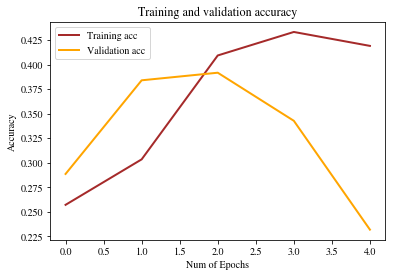

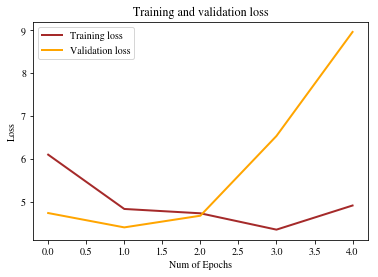

In [84]:
K.clear_session()
# USE THE TRAIN DATA GENERATOR CREATED ABOVE TO GENERATE FIRST FIVE PORTRAITS AND LANDSCAPES
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
data_batch, labels_batch = train_generator[0]
batch_size = len(labels_batch)
print(batch_size)

def reduce_overfit_model():

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(batch_size, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pool4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool5'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(4, kernel_initializer='glorot_uniform', activation='relu', name='fc2'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = 'rmsprop',
                  #optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

cnn_reduce_overfit = reduce_overfit_model()
cnn_reduce_overfit .summary()

# Fit model
history_reduce_overfit = cnn_reduce_overfit.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=1, 
    callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])
    
plot_accuracies_loss(history_reduce_overfit)

# PLOT ROC CURVE

In [89]:
### PICK THE BEST MODEL #####
best_model = cnn_reduce_overfit

# GET ACCURACY SCORE ON THE TEST SET
test_loss, test_acc = best_model.evaluate_generator(test_generator, steps=100)
print('\nTEST accuracy:', test_acc)
print('TEST loss:', test_loss)


predictions = []
labels = []
indexes = []
i = 0
for data_batch, labels_batch in test_generator:
    labels.extend(labels_batch)
    predictions.extend(best_model.predict(data_batch).T[0])
    i = i + 1
    if i==len(test_generator):
        break
        
for i in range (len(test_generator)):
     indexes.extend(next(test_generator.index_generator))
        
print(test_generator.class_indices)
#print(len(indexes))
print(len(labels))
print(len(predictions))
print(labels)
print(predictions)

#https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
#fpr, tpr, thresholds = roc_curve(labels, predictions)
#auc_data = auc(fpr, tpr)

#plt.figure(figsize=(10,8))
#plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_data))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
#plt.title('ROC curve')
#plt.legend(loc='best')
#plt.show()



TEST accuracy: 0.23316062176165803
TEST loss: 9.162386071496677
{'Chihuahua': 0, 'Japanese_spaniel': 1, 'curly-coated_retriever': 2, 'golden_retriever': 3}
100
100
[array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=floa

In [88]:
### PICK THE BEST MODEL #####
best_model = cnn_reduce_overfit

def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def show_results(model, test_generator):
    # GET ACCURACY SCORE ON THE TEST SET
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
    print('\nTEST accuracy:', test_acc)
    print('TEST loss:', test_loss)
    predictions = []
    labels = []
    indexes = []

    i = 0
        
    for data_batch, labels_batch in test_generator:
        labels.extend(labels_batch)
        predictions.extend(model.predict_classes(data_batch).T[0])
        i = i + 1
        if i==len(test_generator):
            break
        
    for i in range (len(test_generator)):
        indexes.extend(next(test_generator.index_generator))
    print("Lables:")
    print(labels)
    print("Predictions:")
    print(predictions)
    print('Confusion Matrix')
    cm = confusion_matrix(labels, predictions)
    print(cm)
    print('Classification Report')
    target_names = [*test_generator.class_indices.keys()]
    print(classification_report(labels, predictions, target_names=target_names))
    show_confusion_matrix(cm, target_names)
    
show_results(best_model, test_generator)



TEST accuracy: 0.23958333333333334
TEST loss: 8.885819186766943


TypeError: 'numpy.int64' object is not iterable